<a href="https://colab.research.google.com/github/maxreynolds/Pattern-Cloud/blob/main/Pattern_FineTuning_and_Inference_SouderNetExample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pattern Fine-tuning Workflow

This Notebook is an example of the workflow that Pattern is initially supporting. To train stable diffusion on our user's images, we'll use fine-tuning, which involves taking a pre-trained stable diffusion model and training it further on a new dataset. This way, we can leverage the knowledge already learned by the pre-trained model and adapt it to the new dataset, allowing us to achieve better performance with less training time.

In [1]:
# Let's double check that we have the Colab Pro GPU we're paying for (A100 recommended)
!nvidia-smi

Thu Oct 26 18:19:57 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    50W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Installing our Hugging Face Diffusers, Weights and Biases, and some additional requirements
!cd /content/
!git clone https://github.com/maxreynolds/diffusers.git
!pip install ./diffusers
!pip install -U -r /content/diffusers/examples/text_to_image/requirements.txt
!pip install wandb

In [3]:
# Configuring our model, dataset and new model directories
import os

os.environ['MODEL_NAME'] = f'CompVis/stable-diffusion-v1-4'

os.environ['DATASET_NAME'] = f'MaxReynolds/Lee_Souder_Combined'
os.environ['OUTPUT_DIR'] = f'MaxReynolds/SouderRocketLauncherNetCombined-v1-4-400'

In [4]:
from huggingface_hub import notebook_login
notebook_login()

In [5]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

Run our training script using HuggingFace accelerate. We'll be inputing our dataset and model with 400 steps (selected) and 134 epochs (default). The model will then be automatically pushed to the hub.

In [6]:
#Running our training (finetuning) script via HF accelerate

!accelerate launch diffusers/examples/text_to_image/train_text_to_image.py \
  --report_to="wandb" \
  --pretrained_model_name_or_path=$MODEL_NAME \
  --dataset_name=$DATASET_NAME \
  --use_ema \
  --resolution=512 --center_crop --random_flip \
  --train_batch_size=1 \
  --gradient_accumulation_steps=4 \
  --gradient_checkpointing \
  --mixed_precision="fp16" \
  --max_train_steps=400 \
  --learning_rate=1e-05 \
  --max_grad_norm=1 \
  --checkpointing_steps=100000 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --output_dir=$OUTPUT_DIR \
  --validation_prompt="Rocket Launcher by Lee Souder" \
  --push_to_hub \
  --seed=1337


The following values were not passed to `accelerate launch` and had defaults used instead:
	`--num_processes` was set to a value of `1`
	`--num_machines` was set to a value of `1`
	`--mixed_precision` was set to a value of `'no'`
	`--dynamo_backend` was set to a value of `'no'`
To avoid this warning pass in values for each of the problematic parameters or run `accelerate config`.
2023-10-26 18:21:01.445614: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-26 18:21:01.445671: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-26 18:21:01.445712: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has alr

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

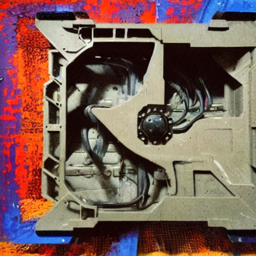

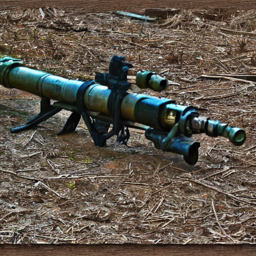

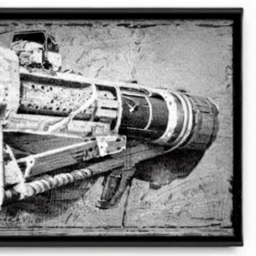

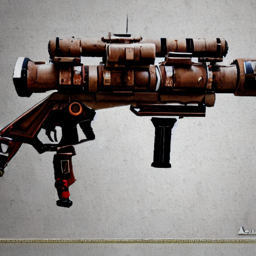

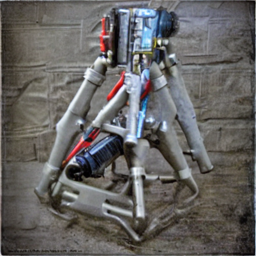

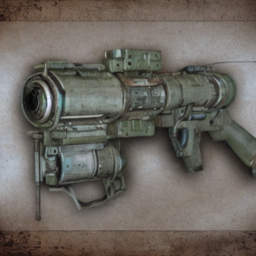

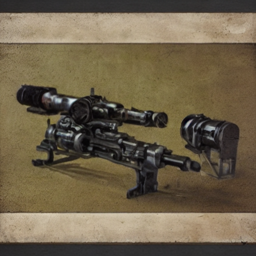

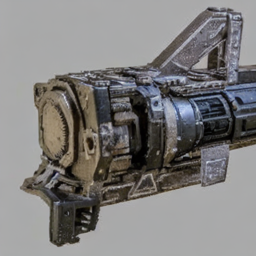

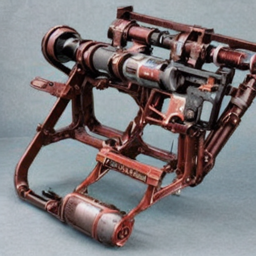

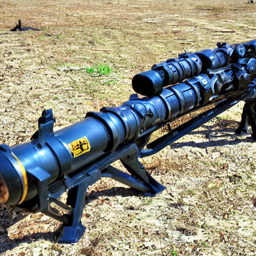

In [7]:
# Now let's Run inference on our new model

from diffusers import StableDiffusionPipeline
import torch
from PIL import Image

# Setting model path to the model we just trained
model_path = 'MaxReynolds/SouderRocketLauncherNetCombined-v1-4-400'
pipe = StableDiffusionPipeline.from_pretrained(model_path, torch_dtype=torch.float16)
pipe.to("cuda")

my_prompt = "Rocket Launcher by Lee Souder"
num_images = 10

# Run inference using above prompt to acquire some number of images
all_images = [pipe(prompt=my_prompt).images[0] for i in range(num_images)]
for idx, image in enumerate(all_images):
  image = image.resize((256, 256))
  image.save(f"image{idx}.png")
  display(image)


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

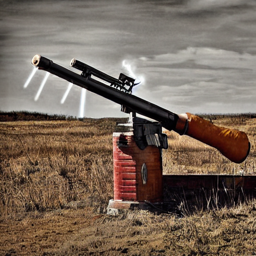

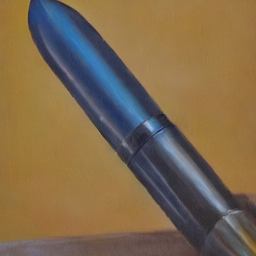

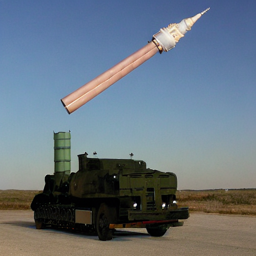

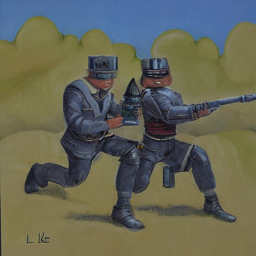

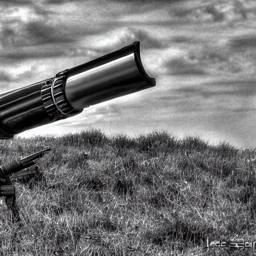

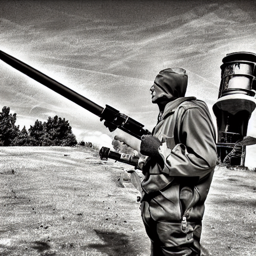

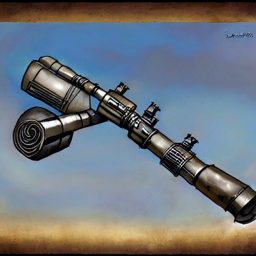

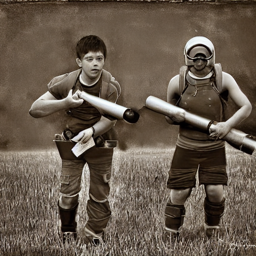

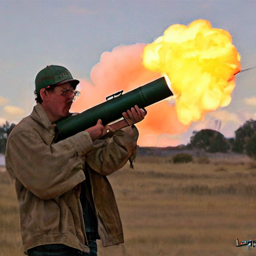

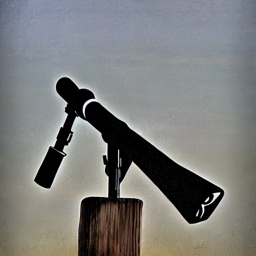

In [ ]:
# And compare that to the results of running inference on the original stable diffusion model (same prompt)

from diffusers import StableDiffusionPipeline
import torch
from PIL import Image

# Setting model path to vanilla SD-1.4
model_path = 'CompVis/stable-diffusion-v1-4'
pipe = StableDiffusionPipeline.from_pretrained(model_path, torch_dtype=torch.float16)
pipe.to("cuda")

my_prompt = "Rocket Launcher by Lee Souder"
num_images = 10

# Run inference using above prompt to acquire some number of images
all_images = [pipe(prompt=my_prompt).images[0] for i in range(num_images)]
for idx, image in enumerate(all_images):
  image = image.resize((256, 256))
  image.save(f"image{idx}.png")
  display(image)
